<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/TAAPC_Assignments/assignment_2_model_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchtext
from tqdm import tqdm
from collections import Counter, OrderedDict

Fetch the data uploaded to GitHub repository

In [2]:
url_train = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_train.csv"
url_test = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_test.csv"

imdb_train = pd.read_csv(url_train)
imdb_test = pd.read_csv(url_test, names=imdb_train.columns)

In [3]:
imdb_test.head()

,review,sentiment
0,"I saw the film many times, and every time I am...",negative
1,I loved KOLCHAK: THE NIGHT STALKER since I saw...,positive
2,This feels as if it is a Czech version of Pear...,positive
3,"When, oh, when will someone like Anchor Bay or...",positive
4,"""Just before dawn "" is one of the best slasher...",positive


In [4]:
print(imdb_train.shape, imdb_test.shape)
print(imdb_train.columns, imdb_test.columns)

(45000, 2) (5000, 2)
Index(['review', 'sentiment'], dtype='object') Index(['review', 'sentiment'], dtype='object')


# Project outline

The outline of this project is:

1. Pre-process the data, **defining a vocabulary** and converting it to a sparse representation.

2. **Pre-train an embedding layer** to transform into a dense representation.

3. Feed embedded input to a GRU layer, and then use a Linear layer with sigmoid activation to map output into a single binary prediction. We should consider only the GRU output for the last sequence input, **i.e many-to-one model**. Note that in practice, the sigmoid activation is implementend implicitly through the loss function, for more numerical stability. 

4. Fine-tune the model by testing stacked GRUs, GRU dropout, bidirectional GRUs. Fine-tune the embedding by freezing its parameters, training the rest of the model for some epochs, then unfreeze and further train the complete model.

**Note:**
We will have to deal with different length sequences while mini-batching. [This post](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e) and [this repository](https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec) explain PyTorch implementations to do that.

The approach is to *pad the input sequences*, and then inside the model:
- Mask the paddings w.r.t Embedding layer (i.e have Embedding always map the padding token to the zero vector)
- Mask the paddings w.r.t GRU layer, since padding do not contain information and should not be considering for parameter optimization

# Stage 1: estabilish the vocabulary

Generate the vocabulary, retaining only words that appear more times than a user-defined threshold.

In [5]:
tokenizer = torchtext.data.get_tokenizer("basic_english")

def get_vocab_freq(data):
    counter = Counter()
    for sentence in data["review"]:
        tokenized_sentence = tokenizer(sentence)
        counter.update(tokenized_sentence)
    return OrderedDict(counter)

imdb_data = pd.concat([imdb_train, imdb_test], axis=0, ignore_index=True) # fetch vocab considering complete data

vocab_freq = get_vocab_freq(imdb_data)

unk_token = "<unk>" # Token representing OOV words
pad_token = "<pad>" # Token representing padding
vocab = torchtext.vocab.vocab(vocab_freq, min_freq=50,
                              specials=[pad_token, unk_token], special_first=True)
vocab.set_default_index(1) # Unknown words will return 1 (matching <unk> token index)

In [6]:
print(len(vocab), vocab[pad_token])

11265 0


Define the maximum sequence length, and accordingly the padding. The idea is to limit the sequence size $s$ to $s_{\text{max}} \le \mu_s + \sigma_s$. This should help balance out computational cost.

In [7]:
sequence_len = [len(tokenizer(seq)) for seq in imdb_data["review"]]
mean_length = np.array(sequence_len).mean()
std_length = np.array(sequence_len).std()
print(f"Mean length: {mean_length}")
print(f"Std length: {std_length}")
print(f"Max/min length: {max(sequence_len), min(sequence_len)}")
PADDED_LENGTH = int(mean_length + std_length)
PADDED_LENGTH

Mean length: 267.66206
Std length: 197.42324619090934
Max/min length: (2752, 8)


465

# Stage 2: pre-train an Embedding

Following what we have done in class, we will implement a Word2Vec model to pre-train our embedding layer with a SkipGram scheme.

We have way too much data for SkipGram model:
$$
\text{total_examples} \approx \text{window_size} \times 45\text{k} \times \text{avg_length} \sim 100\times 10^6
$$
Therefore, we sample about 10-20% of the complete dataset in order to train our embedding with $10 - 20 \,\, \times 10^6$ skip-grams.

Note that we can *only use the training data*, to avoid data leakage during pre-training.

In [8]:
class SkipGramDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, window_width, pad_token):
        self.inputs = []
        self.contexts = []
        vocab_inv = vocab.get_itos()
        self.vocabs = [vocab, vocab_inv]
        # Keep track of number of valid examples (we skip OOV words)
        num_examples = 0
        # Pick input, context pairs as in regular SkipGram
        print("Generating skip-grams...")
        for sequence in data["review"]:
            tokens = tokenizer(sequence)
            length = len(tokens)
            for i, tk in enumerate(tokens):
                # Treat beginning and end of token sequence as special cases
                left_idx, right_idx = i - window_width, i + window_width + 1
                left_idx = 0 if i < window_width else left_idx
                right_idx = length if i > length - (window_width + 1) else right_idx
                for j in range(left_idx, right_idx):
                    if j == i:
                        continue
                    next_tk = tokens[j]
                    self.inputs.append(vocab[tk])
                    self.contexts.append(vocab[next_tk])
                    num_examples += 1
        print("Finished generating skip-grams.")
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        return self.inputs[index], self.contexts[index]
    
    def get_vocabs(self):
        return self.vocabs

In [9]:
WINDOW_WIDTH = 4
sample_size = 0.2
# Sample from train data only to avoid data leakage
imdb_sampled = imdb_train.sample(frac=sample_size, random_state=42)

w2v_dataset = SkipGramDataset(imdb_sampled, vocab, WINDOW_WIDTH, pad_token)
print(f"Dataset has {len(w2v_dataset)} examples.")

Generating skip-grams...
Finished generating skip-grams.
Dataset has 19320384 examples.


Sanity check: visualize some skip grams to inspect if they were generated correctly.

In [10]:
offset = 0
vocab_inv = w2v_dataset.get_vocabs()[1]
for i in range(offset, offset + 50):
    x, y = w2v_dataset[i]
    x_word = vocab_inv[x]
    y_word = vocab_inv[y]
    print(x_word, y_word)

when i
when tuned
when in
when to
i when
i tuned
i in
i to
i my
tuned when
tuned i
tuned in
tuned to
tuned my
tuned local
in when
in i
in tuned
in to
in my
in local
in pbs
to when
to i
to tuned
to in
to my
to local
to pbs
to station
my i
my tuned
my in
my to
my local
my pbs
my station
my last
local tuned
local in
local to
local my
local pbs
local station
local last
local night
pbs in
pbs to
pbs my
pbs local


Define Word2Vec model, which consists on an Embedding layer (mapping to an embedded space of dimension $E$), followed by a Linear layers mapping from the embedded space back to the feature space.

In [11]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_max_norm=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0,
                                      max_norm=embed_max_norm)
        self.linear = nn.Linear(in_features=embed_dim,
                                out_features=vocab_size)
    
    def forward(self, x):
        embedded = self.embedding(x)
        logits = self.linear(embedded)
        return logits

Define training routine and train the model.

Since this training procedure takes between 30 minutes / 1h per epoch, on my GPU...

... it is wise to set up a checkpoint system that saves the model after every epoch.

In [12]:
def w2v_fit(model, train_loader, optimizer, **kwargs):
    
    num_epochs = kwargs.get("num_epochs", 100)
    loss_fn = kwargs.get("loss_fn", nn.functional.cross_entropy)
    device = kwargs.get("device", torch.device("cpu"))
    
    model.train()
    train_loss_hist, train_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        pbar = tqdm(train_loader, total=len(train_loader))
        train_loss, train_acc = 0, 0
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                preds = logits.argmax(dim=1)
            acc = (preds == y).float().sum() / ((y != -100).float().sum() + 1e-6)
            train_loss += loss.item()
            train_acc += acc.item()
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"train loss = {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc)
        # Checkpoint after every epoch since this pre-training is expensive
        path = f"W2VEC_Checkpoint_E{epoch}.pt"
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            }, path)
        
    return train_loss_hist, train_acc_hist

In [16]:
EMBEDDING_DIM = 200
EMBEDDING_MAX_NORM = 1
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4

In [17]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("DEVICE:", DEVICE)

w2v_model = SkipGramModel(vocab_size=len(vocab), embed_dim=EMBEDDING_DIM,
                          embed_max_norm=EMBEDDING_MAX_NORM).to(DEVICE)

optimizer = torch.optim.Adam(w2v_model.parameters(), lr=LEARNING_RATE)
w2v_dataloader = torch.utils.data.DataLoader(w2v_dataset, batch_size=BATCH_SIZE, shuffle=True)

DEVICE: cuda


In [18]:
train_loss, train_acc = w2v_fit(w2v_model, w2v_dataloader,
                                optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)

Epoch 1


loss = 5.937 | acc = 0.094: 100%|██████████████████████████████████████████████| 150941/150941 [27:50<00:00, 90.37it/s]


train loss = 6.226 | train acc = 0.063
Epoch 2


loss = 5.830 | acc = 0.094: 100%|██████████████████████████████████████████████| 150941/150941 [26:04<00:00, 96.49it/s]


train loss = 6.101 | train acc = 0.067
Epoch 3


loss = 6.067 | acc = 0.062: 100%|██████████████████████████████████████████████| 150941/150941 [26:39<00:00, 94.39it/s]


train loss = 6.077 | train acc = 0.067
Epoch 4


loss = 6.707 | acc = 0.062: 100%|██████████████████████████████████████████████| 150941/150941 [26:42<00:00, 94.20it/s]


train loss = 6.062 | train acc = 0.067
Epoch 5


loss = 5.718 | acc = 0.094: 100%|██████████████████████████████████████████████| 150941/150941 [26:46<00:00, 93.96it/s]


train loss = 6.052 | train acc = 0.067
Epoch 6


loss = 6.481 | acc = 0.062: 100%|██████████████████████████████████████████████| 150941/150941 [25:53<00:00, 97.17it/s]


train loss = 6.044 | train acc = 0.067
Epoch 7


loss = 5.938 | acc = 0.078: 100%|██████████████████████████████████████████████| 150941/150941 [25:54<00:00, 97.10it/s]


train loss = 6.038 | train acc = 0.067
Epoch 8


loss = 6.110 | acc = 0.047: 100%|██████████████████████████████████████████████| 150941/150941 [25:30<00:00, 98.61it/s]


train loss = 6.033 | train acc = 0.067
Epoch 9


loss = 5.328 | acc = 0.141: 100%|██████████████████████████████████████████████| 150941/150941 [25:46<00:00, 97.60it/s]


train loss = 6.029 | train acc = 0.067
Epoch 10


loss = 6.432 | acc = 0.047: 100%|██████████████████████████████████████████████| 150941/150941 [26:19<00:00, 95.56it/s]

train loss = 6.025 | train acc = 0.067


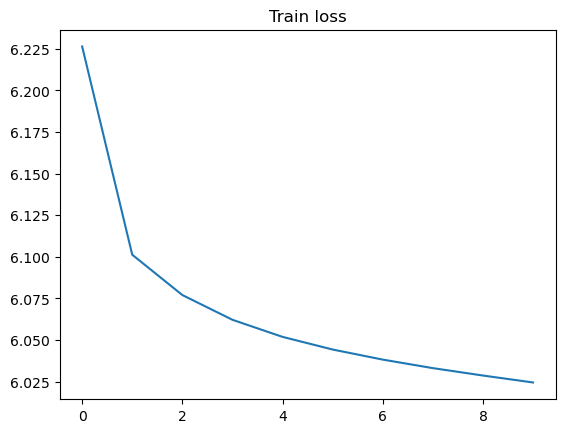

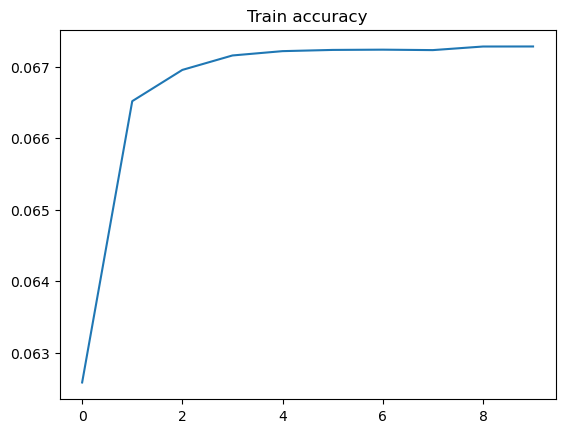

In [28]:
plt.title('Train loss')
plt.plot(range(len(train_loss)), train_loss)
plt.show()
plt.title('Train accuracy')
plt.plot(range(len(train_acc)), train_acc)
plt.show()

Save the model, and/or load a trained model

In [20]:
torch.save(w2v_model.state_dict(), f"imdb_word2vec_E{EMBEDDING_DIM}_EMN{EMBEDDING_MAX_NORM}_v4.pt")

In [21]:
# Model to load
MODEL_TO_LOAD = f"imdb_word2vec_E{EMBEDDING_DIM}_EMN{EMBEDDING_MAX_NORM}_v4.pt"
MODEL_TO_LOAD

'imdb_word2vec_E200_EMN1_v4.pt'

Let's inspect our model quality by computing the Cosine Similarity between embeddings and inspecting the top N similar words to a given input.

In [22]:
embeddings_norm = np.zeros((len(vocab), len(vocab)))
for token_idx in range(len(vocab)):
    token_idx = torch.tensor(token_idx).to(DEVICE)
    embedding = w2v_model(token_idx)
    embedding /= (embedding**2).sum().sqrt()
    embeddings_norm[token_idx] = embedding.detach().cpu().numpy()

In [23]:
def get_most_similar(word, vocab, vocab_inv, embeddings, topN=1):
    print(f"Input word index: {vocab[word]}")      
    embedded_word = embeddings[vocab[word]] # Already normalized
    sim_measure = np.zeros(len(vocab))
    for idx, embed in enumerate(embeddings):
        # Compute cosine similarity
        cos_sim = embedded_word.dot(embed)
        sim_measure[idx] = cos_sim
    # Remove self-similarity
    sim_measure[vocab[word]] = 0.
    # Retrieve N most similar
    most_similar = np.argpartition(sim_measure, -topN)[-topN:]
    topN_dict = {vocab_inv[idx]: sim_measure[idx] for idx in most_similar}
    return topN_dict

In [24]:
for word in ["bad", "good", "actor", "lighting", "long", "horror", "twist"]:
    print(f"Top-10 words most similar to '{word}': {get_most_similar(word, vocab, vocab_inv, embeddings_norm, topN=10)}\n")

Input word index: 560
Top-10 words most similar to 'bad': {'revolting': 0.9977063704070424, 'sucks': 0.9977270704214943, 'terrible': 0.9984158655393882, 'poor': 0.9977693891162736, 'worse': 0.9977471648086524, 'lame': 0.9977902103365757, 'good': 0.9980058807118604, 'horrible': 0.9982743309596288, 'awful': 0.998380374199984, 'lousy': 0.9981834004143826}

Input word index: 429
Top-10 words most similar to 'good': {'tricky': 0.9976163786797123, 'lousy': 0.9976556114397701, 'f/x': 0.9976826113651118, 'fine': 0.9979062140351438, 'poor': 0.9976914093456444, 'decent': 0.9988721777656079, 'funny': 0.997717932855538, 'bad': 0.9980058807118604, 'nice': 0.99799225299496, 'great': 0.9982215713546532}

Input word index: 965
Top-10 words most similar to 'actor': {'talented': 0.9977810490543682, 'kevin': 0.9977819634233478, 'oscar': 0.9979449068429336, 'brosnan': 0.997850356853333, 'role': 0.998660008032582, 'pacino': 0.9978488525079958, 'nomination': 0.9977840519532966, 'comedian': 0.998010441532560

# Stage 3: tackle Sentiment Analysis task

Create a custom `Dataset` and `DataLoader` to automatically handle mini-batching.

The `IMDBDataset` object should store each review in a sparse representation and map the sentiment into binary categories: `{0: "negative", 1: "positive"}`.

Moreover, it will pad each review with `<pad>` tokens. This will be managed later by the `pack_padded_sequence` and `pad_packed_sequence` functions.

In [29]:
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, tokenizer, max_len, pad_token):
        self.inputs = []
        self.targets = []
        self.lengths = []

        print(f"Loading data...")
        print(f"Padding inputs...")
        for sentence in data["review"]:
            # Tokenize review
            tokenized_sentence = tokenizer(sentence)
            # Crop to maximum allowed size
            if len(tokenized_sentence) > max_len:
                tokenized_sentence = tokenized_sentence[:max_len]
                padded_sentence = [vocab[tk] for tk in tokenized_sentence] 
            else:
                padded_sentence = [vocab[tk] for tk in tokenized_sentence] 
            # Save length before padding
            self.lengths.append(len(padded_sentence)) 
            # Apply padding
            padding_size = max_len - len(padded_sentence)
            padded_sentence.extend([vocab[pad_token]]*padding_size)
            # Append result
            self.inputs.append(padded_sentence)
        print("Finished padding inputs. Processing labels...")
        for label in data["sentiment"]:
            self.targets.append(0 if label == "negative" else 1)
        print("Done.")

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        # Must also return original length before padding
        return {"inputs": self.inputs[idx],
                "targets": self.targets[idx],
                "lengths": self.lengths[idx]}
        # return self.inputs[idx], self.targets[idx], self.lengths[idx]

Instantiate the `DataLoaders`, splitting the train data into train/validation sets. For the train/validation splitting, refer [to this post.](https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-random-split-data-set/)

In [30]:
train_dataset = IMDBDataset(imdb_train, vocab, tokenizer, PADDED_LENGTH, pad_token)
test_dataset = IMDBDataset(imdb_test, vocab, tokenizer, PADDED_LENGTH, pad_token)

train_split = int(0.9 * len(train_dataset))
validation_split = len(train_dataset) - train_split
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [train_split, validation_split])

BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"PADDING LENGTH: {PADDED_LENGTH}")

Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.
Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.
PADDING LENGTH: 465


Now we need to define our model:

[![](https://mermaid.ink/img/pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)](https://mermaid.live/edit#pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)

[This implementation](https://github.com/chrisvdweth/ml-toolkit/blob/master/pytorch/models/text/classifier/rnn.py) is a nice reference, since it deals with many permuatations of this basic architecture.

Some comments:
- Unlike the Word2Vec model implemented in class, we don't need to use a `nn.Linear` layer to map from embedding space to vocabulary space. 

- We should load weights the Word2Vec we trained above into the sentiment analysis model Embedding layer. Note this fixes its embedding size. 

- After initializing the pre-trained weights, we can freeze them to avoid getting messed up by the first epochs. A common strategy is to later unfreeze these layers for fine-tuning the embedding.

- The model is based around a `nn.GRU` layer, which allow us to chain many GRU units for processing each sequence. In the end, we are only interest in the output of the final GRU layer. 

- Note that we will use `torch.nn.utils.rnn.pack_padded_sequence` to feed input to GRU as to avoid flooding it with padding tokens. The output will still be in packed form, but it is not necessary to reverse the operation since our prediction is based upon the hidden state.

- We don't need to include `nn.Sigmoid` explicitly, since our loss function (`nn.BCEWithLogitsLoss`) will implement it for us (with more numerical stability, [c.f. documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)).

In [31]:
class GRUPredictor(nn.Module):

    def __init__(self, vocab_size,
                 hidden_size, num_layers, is_bidirectional=True, dropout=0,
                 embed_dim=300, embed_max_norm=None, pretrained=None):
        super().__init__()
        

        self.D = 2 if is_bidirectional else 1
        if pretrained is not None:
            # pre-trained weights are frozen by default
            self.embedding = self.set_pretrained(pretrained,
                                                 padding_idx=0,
                                                 max_norm=embed_max_norm)
        else:
            self.embedding = nn.Embedding(vocab_size, embed_dim,
                                          padding_idx=0,
                                          max_norm=embed_max_norm)

        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional=is_bidirectional,
                          dropout=dropout)
        self.linear = nn.Linear(self.D*hidden_size, 1)
        # Apply Xavier initialization to linear layer with (implicit) sigmoid activation
        nn.init.xavier_uniform_(self.linear.weight, gain=1.0)

        # Record some hyper-parameters
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        
    def forward(self, inputs, unpadded_lengths):
        # embed inputs
        embedded_inputs = self.embedding(inputs)
        BS, T, _ = embedded_inputs.shape # X -> batch, steps, embed_dim 
        # initialize hidden state
        self.hidden_state = torch.zeros((self.D*self.num_layers, BS, self.hidden_size),
                                        device=inputs.device)
        # pack_padded_sequence so that padded items in the sequence won't be shown to the GRU
        X = torch.nn.utils.rnn.pack_padded_sequence(embedded_inputs, unpadded_lengths,
                                                    batch_first=True, enforce_sorted=False)

        # recursive pass
        X, self.hidden_state = self.gru(X, self.hidden_state)
        
        # concatenate hidden state for forward/backward, for the last layer
        final_state = self.hidden_state.view(self.num_layers,
                                             self.D,
                                             BS, # batch size
                                             self.hidden_size)[-1]
        final_hidden_state = None
        if self.D == 1:
            final_hidden_state = final_state.squeeze()
        else:
            h_1, h_2 = final_state[0], final_state[1]
            final_hidden_state = torch.cat((h_1, h_2), 1)
        logits = self.linear(final_hidden_state)
        return logits  
    
    def set_pretrained(self, path, padding_idx, max_norm):
        print("Loading pre-trained weights...")
        state_dict = torch.load(path)
        pretrained_weights = state_dict["embedding.weight"]
        print("Done.")
        return nn.Embedding.from_pretrained(pretrained_weights,
                                            freeze=True, # Frozen weights by default
                                            padding_idx=padding_idx, # Note that padding tokens won't contribute to gradient
                                            max_norm=max_norm) 

    def unfreeze_embedding(self):
        print("Unfreezing embedding layer...")
        self.embedding.weight.requires_grad = True
        print("Done.")

Now we need to write the training loop, etc.
Most of the base code below comes from what was supplied to us in the earlier modules.

Comment about `nn.functional.binary_cross_entropy_with_logits`: the targets $y$ need to be a float tensor, since the loss function can work with soft labels representing probability of the positive class.
[Source](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3)

In [57]:
HIDDEN_SIZE = 20 # dimension of GRU hidden state
NUM_LAYERS = 2 # number of GRU layers
LEARNING_RATE = 1e-3 # starting learning rate
NUM_EPOCHS = 5 # for training with embedding frozen
BIDIRECTIONAL = True # single or bidirectional GRU
DROPUT_RATE = 0 # dropout between GRU layers

# number of epochs to fine-tune embedding
NUM_EPOCHS_POST_UNFREEZE = 5

# train on GPU if possible
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
    

print("DEVICE:", DEVICE)
print("EMBEDDING DIM:", EMBEDDING_DIM)

model = GRUPredictor(len(vocab), HIDDEN_SIZE, NUM_LAYERS, is_bidirectional=BIDIRECTIONAL, dropout=DROPUT_RATE,
                     embed_dim=EMBEDDING_DIM, embed_max_norm=True, pretrained=MODEL_TO_LOAD).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# decrease learning rate after unfreezing embedding layer
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[NUM_EPOCHS], verbose=True)

DEVICE: cuda
EMBEDDING DIM: 200
Loading pre-trained weights...
Done.
Adjusting learning rate of group 0 to 1.0000e-03.


Check how many parameters the model defined above has:

In [61]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"The model has {pytorch_trainable_params} trainable parameters " \
      + f"and {pytorch_total_params - pytorch_trainable_params} non-trainable parameters")
print(f"Total: {pytorch_total_params}")

The model has 34121 trainable parameters and 2253000 non-trainable parameters
Total: 2287121


We will try to visualize the gradient flow using [the code provided here.](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/7)

Basically, for each layer's weights, get gradients and plot the average value and the maximum value. We should see considerable values throughout the network if the gradient is flowing properly during training.

In [62]:
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    from matplotlib.lines import Line2D
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    ave_grads = torch.tensor(ave_grads).cpu().numpy()
    max_grads = torch.tensor(max_grads).cpu().numpy()
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'],
                loc="upper right")

Look at model summary to see if everything is as expected

In [63]:
print(model)

GRUPredictor(
  (embedding): Embedding(11265, 200, padding_idx=0, max_norm=True)
  (gru): GRU(200, 20, num_layers=2, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=40, out_features=1, bias=True)
)


Define the training routine, with validation pass.

Remember to include the learning rate scheduler *after* optimizer update, and to unfreeze the embedding layer after a initial training round in order to fine-tune it.

In [64]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss, avg_acc = 0., 0.
    for i, batch in pbar:

        batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
        batch["targets"] = batch["targets"].float().to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            preds = model(batch["inputs"], batch["lengths"])
            probas = torch.sigmoid(preds)
            pred_cats = torch.where(probas > 0.5, 1, 0).squeeze()
            acc = (pred_cats == batch["targets"]).float().sum()
            acc /= len(batch["targets"])
           
        loss = loss_fn(preds.squeeze(), batch["targets"])
        avg_loss += loss.item()
        avg_acc += acc.item()
        pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
    avg_loss /= len(data_loader)
    avg_acc /= len(data_loader)
    return avg_loss, avg_acc

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get("num_epochs", 100)
    num_epochs_post_unfreeze = kwargs.get("num_epochs_post_unfreeze", 0)
    if num_epochs_post_unfreeze > 0:
        num_epochs += num_epochs_post_unfreeze
    loss_fn = kwargs.get("loss_fn", nn.BCEWithLogitsLoss())
    device = kwargs.get("device", torch.device("cpu"))
    
    
    train_loss_hist, val_loss_hist = [], []
    train_acc_hist, val_acc_hist = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss, train_acc = 0., 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
            batch["targets"] = batch["targets"].float().to(device)
    
            model.zero_grad() # initialize gradients to zero
            preds = model(batch["inputs"], batch["lengths"]) # forward pass
            loss = loss_fn(preds.squeeze(), batch["targets"]) # loss computation
            loss.backward() # computing gradients (backward pass)
            plot_grad_flow(model.named_parameters()) # visualize gradient flow
            optimizer.step() # updating the parameters of the model
            # accuracy computation
            with torch.no_grad():
                probas = torch.sigmoid(preds)
                pred_cats = torch.where(probas > 0.5, 1, 0).squeeze()
                acc = (pred_cats == batch["targets"]).float().sum()
                acc /= len(batch["targets"])
            # pop computational graph
            train_loss += loss.item()
            train_acc += acc.item() 
            pbar.set_description(f"loss = {loss:.3f} | acc = {acc:.3f}")
        
        # unfreeze the embedding layer after some epochs to fine-tune it
        if epoch + 1 == num_epochs - num_epochs_post_unfreeze:
            model.unfreeze_embedding()
        scheduler.step() # update LR after embedded is set to trainable
        plt.show() # display gradient flow graph
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        print(f"Train loss: {train_loss:.3f} | train acc = {train_acc:.3f}")
        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_acc) 
        
        val_loss, val_acc = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f} | val acc = {val_acc:.3f}")
        val_loss_hist.append(val_loss)
        val_acc_hist.append(val_acc)
        
    return train_loss_hist, val_loss_hist, train_acc_hist, val_acc_hist



Epoch 1/10


loss = 0.539 | acc = 0.769: 100%|████████████████████████████████████████████████████| 317/317 [00:42<00:00,  7.48it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


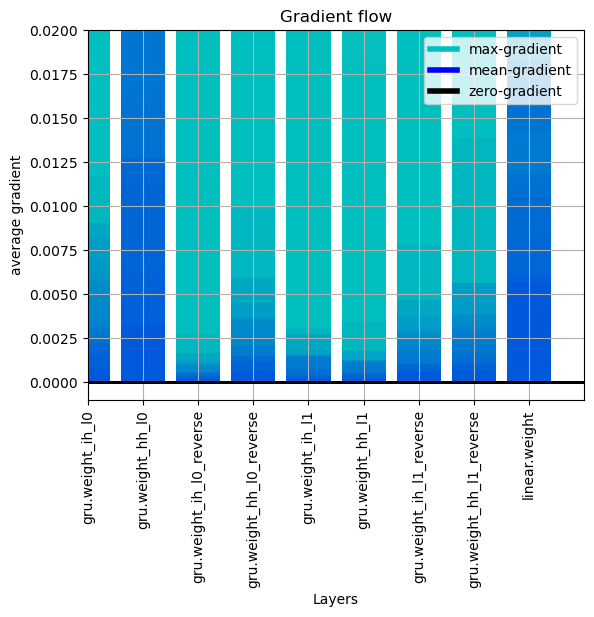

Train loss: 0.519 | train acc = 0.723


loss = 0.287 | acc = 0.900: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 29.04it/s]


Validation loss: 0.383 | val acc = 0.831

Epoch 2/10


loss = 0.402 | acc = 0.885: 100%|████████████████████████████████████████████████████| 317/317 [00:40<00:00,  7.85it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


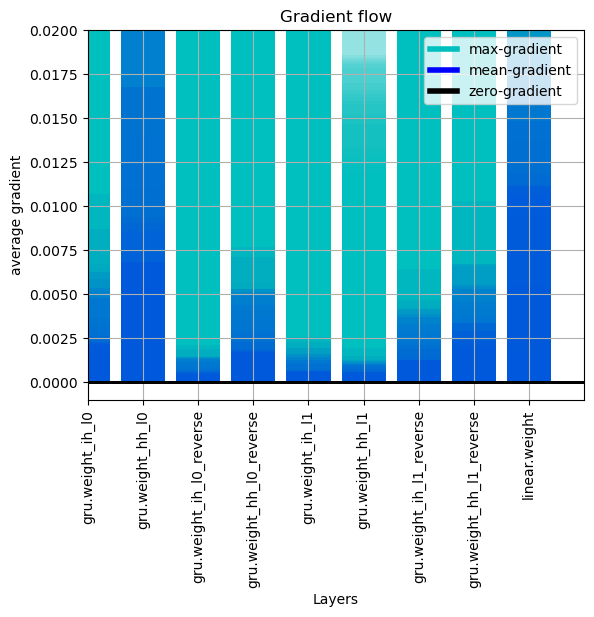

Train loss: 0.363 | train acc = 0.843


loss = 0.271 | acc = 0.900: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 21.64it/s]


Validation loss: 0.338 | val acc = 0.857

Epoch 3/10


loss = 0.314 | acc = 0.846: 100%|████████████████████████████████████████████████████| 317/317 [00:53<00:00,  5.89it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


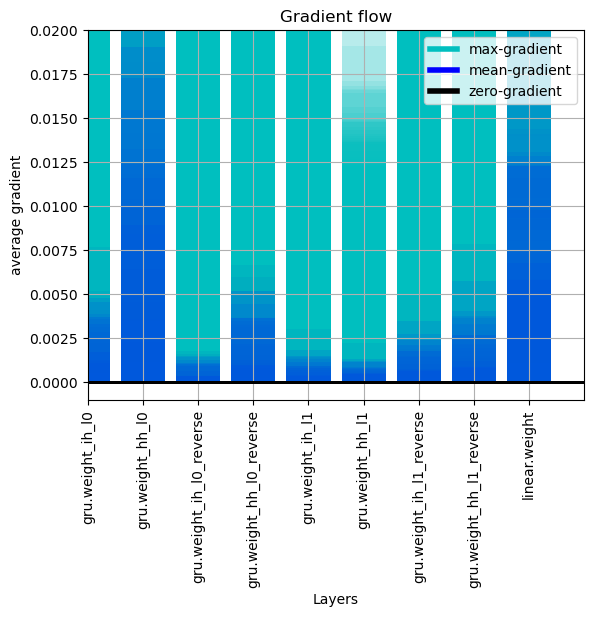

Train loss: 0.329 | train acc = 0.859


loss = 0.275 | acc = 0.900: 100%|██████████████████████████████████████████████████████| 36/36 [00:02<00:00, 15.80it/s]


Validation loss: 0.313 | val acc = 0.869

Epoch 4/10


loss = 0.257 | acc = 0.904: 100%|████████████████████████████████████████████████████| 317/317 [00:45<00:00,  6.95it/s]


Adjusting learning rate of group 0 to 1.0000e-03.


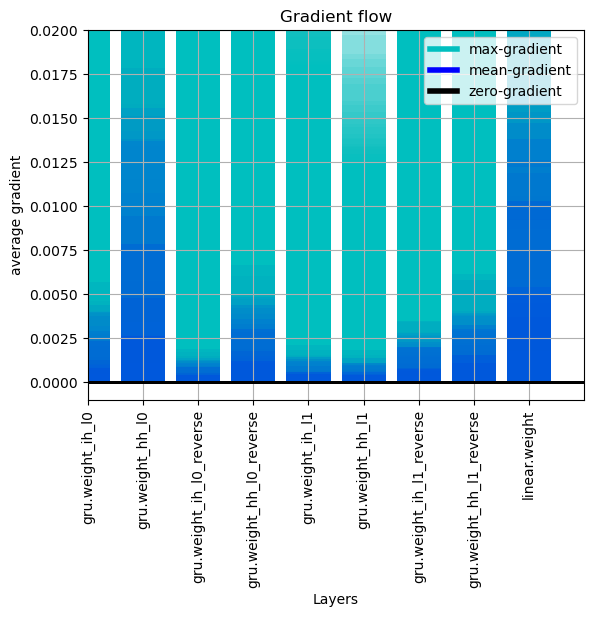

Train loss: 0.302 | train acc = 0.872


loss = 0.238 | acc = 0.900: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 26.38it/s]


Validation loss: 0.294 | val acc = 0.874

Epoch 5/10


loss = 0.481 | acc = 0.827: 100%|████████████████████████████████████████████████████| 317/317 [00:38<00:00,  8.23it/s]


Unfreezing embedding layer...
Done.
Adjusting learning rate of group 0 to 1.0000e-04.


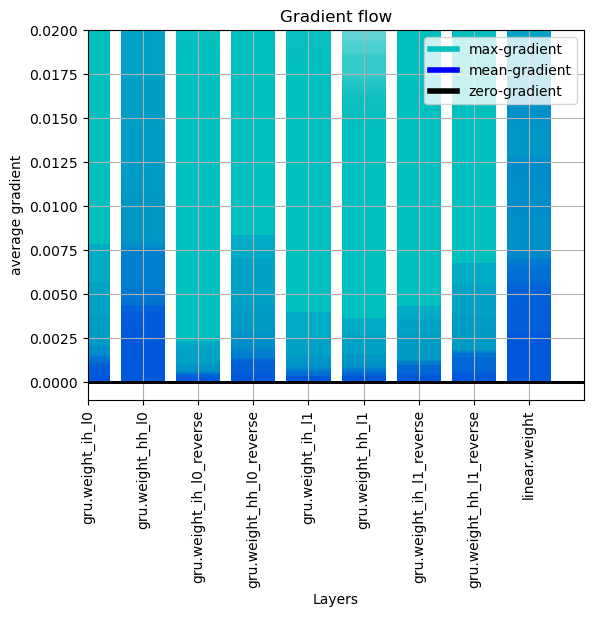

Train loss: 0.287 | train acc = 0.879


loss = 0.288 | acc = 0.850: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 20.75it/s]


Validation loss: 0.286 | val acc = 0.878

Epoch 6/10


loss = 0.209 | acc = 0.942: 100%|████████████████████████████████████████████████████| 317/317 [00:40<00:00,  7.82it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


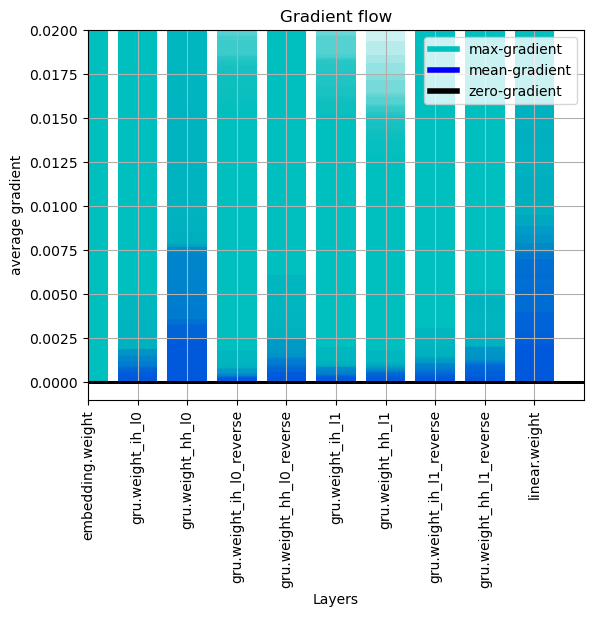

Train loss: 0.251 | train acc = 0.897


loss = 0.196 | acc = 0.900: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 27.34it/s]


Validation loss: 0.240 | val acc = 0.902

Epoch 7/10


loss = 0.141 | acc = 0.962: 100%|████████████████████████████████████████████████████| 317/317 [00:42<00:00,  7.44it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


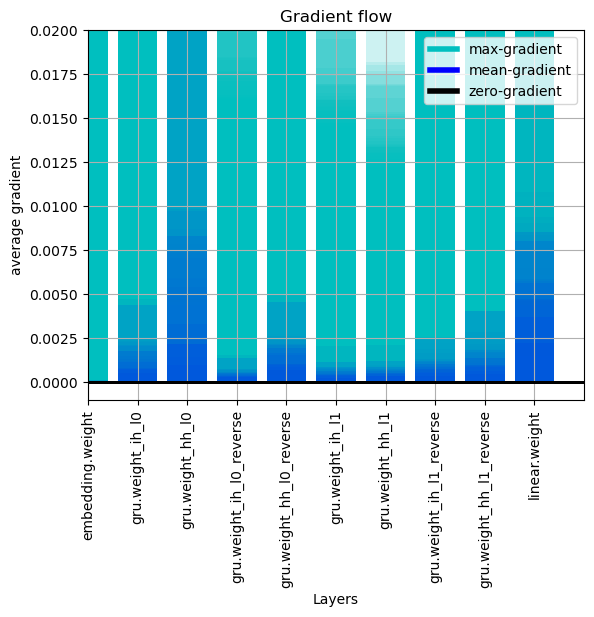

Train loss: 0.202 | train acc = 0.922


loss = 0.160 | acc = 0.950: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.90it/s]


Validation loss: 0.227 | val acc = 0.910

Epoch 8/10


loss = 0.236 | acc = 0.885: 100%|████████████████████████████████████████████████████| 317/317 [00:39<00:00,  8.04it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


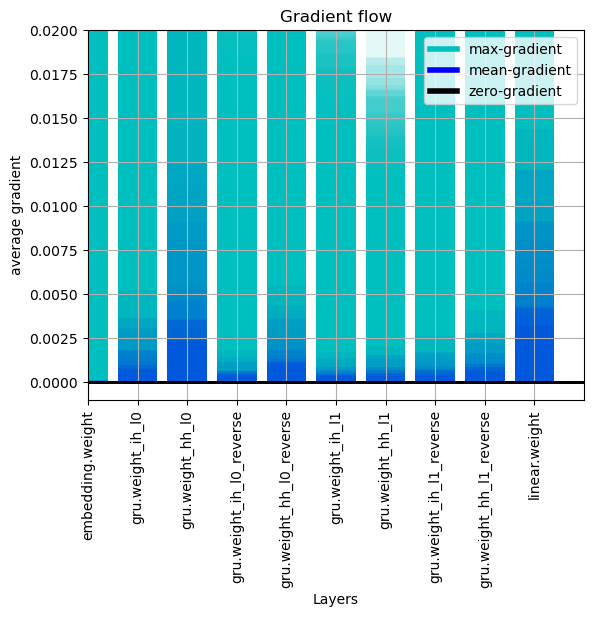

Train loss: 0.169 | train acc = 0.937


loss = 0.146 | acc = 0.950: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 23.08it/s]


Validation loss: 0.225 | val acc = 0.911

Epoch 9/10


loss = 0.055 | acc = 0.981: 100%|████████████████████████████████████████████████████| 317/317 [00:40<00:00,  7.88it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


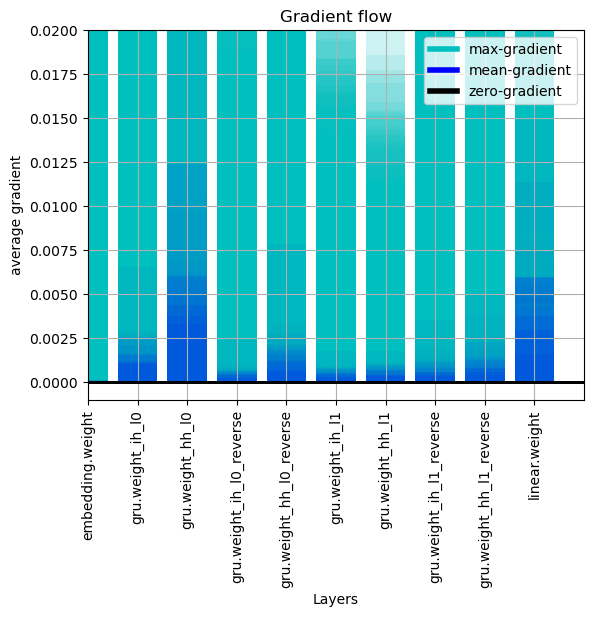

Train loss: 0.142 | train acc = 0.950


loss = 0.109 | acc = 0.950: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 24.65it/s]


Validation loss: 0.237 | val acc = 0.910

Epoch 10/10


loss = 0.212 | acc = 0.923: 100%|████████████████████████████████████████████████████| 317/317 [00:40<00:00,  7.87it/s]


Adjusting learning rate of group 0 to 1.0000e-04.


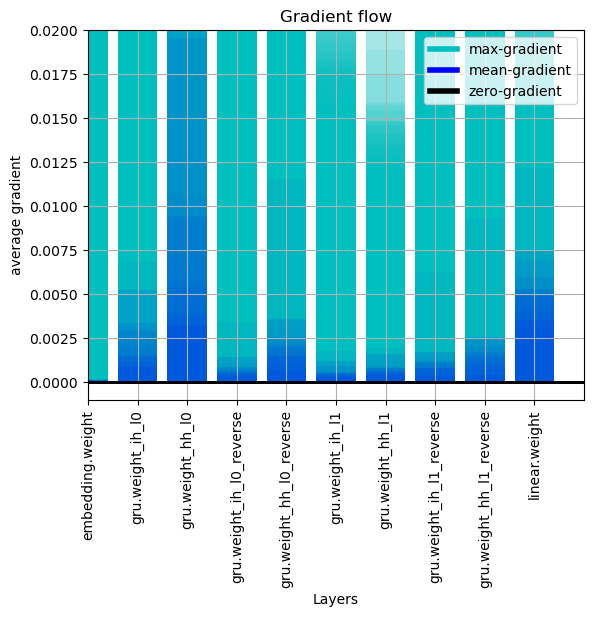

Train loss: 0.119 | train acc = 0.960


loss = 0.133 | acc = 0.950: 100%|██████████████████████████████████████████████████████| 36/36 [00:01<00:00, 25.96it/s]

Validation loss: 0.247 | val acc = 0.911


In [65]:
train_loss, val_loss, train_acc, val_acc = fit(model, train_dataloader, validation_dataloader,
                                               optimizer, num_epochs=NUM_EPOCHS, device=DEVICE,
                                               num_epochs_post_unfreeze=NUM_EPOCHS_POST_UNFREEZE)

Plot training/validation history, to inspect under/overfitting.

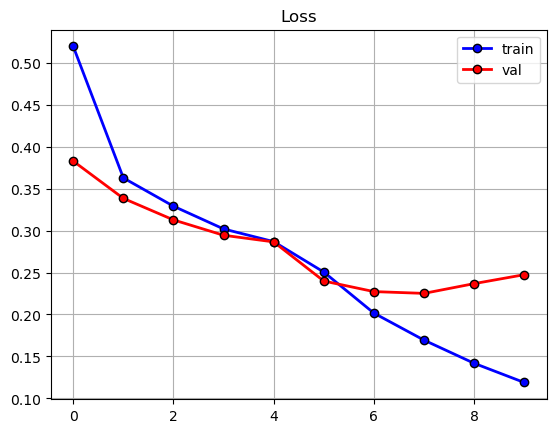

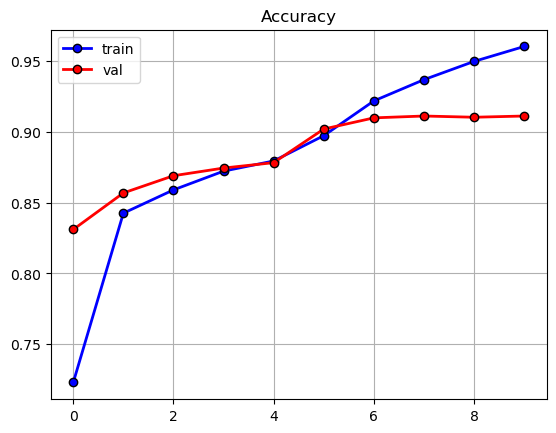

In [67]:
plt.title('Loss')
plt.plot(range(len(train_loss)), train_loss, label="train", marker="o",
         color="blue", mec="k", lw=2.0)
plt.plot(range(len(val_loss)), val_loss, label="val", marker="o",
         color="red", mec="k", lw=2.0)
plt.legend()
plt.grid()
plt.show()
plt.title('Accuracy')
plt.plot(range(len(train_acc)), train_acc, label="train", marker="o",
         color="blue", mec="k", lw=2.0)
plt.plot(range(len(val_acc)), val_acc, label="val", marker="o",
         color="red", mec="k", lw=2.0)
plt.legend()
plt.grid()
plt.show()

Save the model

In [120]:
# model_name = f"GRU_{NUM_EPOCHS}_E{EMBEDDING_DIM}_H{HIDDEN_SIZE}_" +\
#              f"N{NUM_LAYERS}_Bi{1 if BIDIRECTIONAL else 0}_D{DROPUT_RATE}.pt"
# torch.save(model.state_dict(), model_name)

Define routine to use the model for predictions.

In [69]:
def predict(model, data_loader, **kwargs):
    device = kwargs.get('device', torch.device('cpu'))
    
    model.eval()
    total_acc = 0
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for i, batch in pbar:
        batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
        batch["targets"] = batch["targets"].float().to(device)
        
        with torch.no_grad(): # no need to compute gradients
            logits = model(batch["inputs"], batch["lengths"])
            probas = torch.sigmoid(logits)
            pred_cats = torch.where(probas > 0.5, 1, 0).squeeze()
            acc = (pred_cats == batch["targets"]).float().sum()
            acc /= len(batch["targets"])
        total_acc += acc.item()
    total_acc /= len(data_loader)
    return total_acc

Validate the model by predicting on test data. Accuracy should be about the same as in validation.

In [70]:
test_acc = predict(model, test_dataloader, device=DEVICE)
print(f"Test accuracy: {test_acc}")

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 25.43it/s]

Test accuracy: 0.913671875


For user-defined inputs, we need to apply some pre-processing before feeding into trained model for prediction.

In [71]:
def process_review(sentence, tokenizer, vocab, max_len):
        # Tokenize review
        tokenized_sentence = tokenizer(sentence)
        # Crop to maximum allowed size
        if len(tokenized_sentence) > max_len:
            tokenized_sentence = tokenized_sentence[:max_len]
            padded_sentence = [vocab[tk] for tk in tokenized_sentence] 
        else:
            padded_sentence = [vocab[tk] for tk in tokenized_sentence] 
        # Apply padding
        padding_size = max_len - len(padded_sentence)
        padded_sentence.extend([vocab[pad_token]]*padding_size)
        # Append result
        return torch.tensor(padded_sentence).unsqueeze(0)
    

In [117]:
my_review = "The new, acclaimed and horribly popular Top Gun sequel is just the same boring blockbuster with the latest special effects to appeal to the standards these days. The cinemas will be absolutely packed and the movie will keep striking hits at the box office, but it's just Tom Cruise returning for another 2-hour round of exciting dogfights, poor story and bad pacing."

tk_review.shape

torch.Size([1, 465])

In [118]:
preds = model(tk_review.to(DEVICE), torch.tensor([len(my_review)]).cpu().numpy())
probas = torch.sigmoid(preds)
pred_cats = torch.where(probas > 0.5, 1, 0).squeeze()
print(probas)

tensor([[0.7851]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [119]:
print(f'Review:\n{my_review}')
if pred_cats.item() < 1:
    print('Negative')
else:
    print('Positive')

Review:
The new, acclaimed and horribly popular Top Gun sequel is just the same boring blockbuster with the latest special effects to appeal to the standards these days. The cinemas will be absolutely packed and the movie will keep striking hits at the box office, but it's just Tom Cruise returning for another 2-hour round of exciting dogfights, poor story and bad pacing.
Positive
